# AB_testing

In [1]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',effect_size = sms.proportion_effectsize(0.13, 0.15)   
        
mpl.rc('font', **font)

### Finding sample size

We are looking for an effect of +2% from 12 - 14%

In [14]:
effect_size = sms.proportion_effectsize(0.12, 0.14)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

4433


We'd need **at least 4433 observations for each group**. 

Having set the `power` parameter to 0.8 in practice means that if there exists an actual difference in conversion rate between our designs, assuming the difference is the one we estimated (12% vs. 14%), we have about 80% chance to detect it as statistically significant in our test with the sample size we calculated.

## 2. Collecting and preparing the data

In [15]:
df=pd.read_csv(r'ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


### Cleaning the Data

In [24]:
# To make sure all the control group are seeing the old page and viceversa

pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


We'll remove anyone who has seen the wrong page

In [27]:
df.drop(index=df[(df['group']=='control')&(df['landing_page']=='new_page')].index, inplace=True)
df.drop(index=df[(df['group']=='treatment')&(df['landing_page']=='old_page')].index, inplace=True)

In [30]:
# Check if any users appear more than once

session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

multi_users

1

We'll remove this one user

In [36]:
df=df[~df['user_id'].isin(session_counts[session_counts > 1].index)]

In [37]:
df.shape

(290583, 5)

### Sampling

Now that our DataFrame is nice and clean, we can proceed and sample `n=4433` entries for each of the groups. We can use pandas' `DataFrame.sample()` method to do this, which will perform Simple Random Sampling for us. 

**Note**: I've set `random_state=23`

In [60]:
control_sample = df[df['group'] == 'control'].sample(n=required_n , random_state=23)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n , random_state=23)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [61]:
ab_test.head()

,user_id,timestamp,group,landing_page,converted
0,887338,2017-01-12 06:53:21.417894,control,old_page,1
1,704149,2017-01-06 08:58:33.492141,control,old_page,0
2,700197,2017-01-16 06:42:26.997856,control,old_page,0
3,756475,2017-01-07 01:58:03.432851,control,old_page,0
4,648976,2017-01-05 10:23:11.573391,control,old_page,0


In [62]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8866 entries, 0 to 8865
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       8866 non-null   int64 
 1   timestamp     8866 non-null   object
 2   group         8866 non-null   object
 3   landing_page  8866 non-null   object
 4   converted     8866 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 346.5+ KB


In [63]:
ab_test['group'].value_counts()

control      4433
treatment    4433
Name: group, dtype: int64

We now have two groups of adequate size to compare the effect of landing page on conevrsion rate

## 3. Visualising the results

In [64]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.324,0.005
treatment,0.126,0.332,0.005


Judging by the stats above, it does look like **our two designs performed similarly**, with our new design performing slightly better, approx. **12.0% vs. 12.6% conversion rate**.

Plotting the data will make these results easier to grasp:

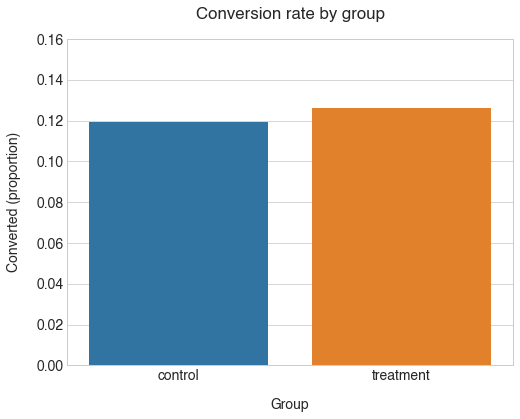

In [50]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.16)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

The conversion rates for our groups are indeed close.

The treatment group's value is higher, the question is now: **Is this difference *statistically significant?***

## 4. Testing the hypothesis

The last step of our analysis is testing our hypothesis. Since we have a very large sample, we can use the normal approximation for calculating our  𝑝
 -value (i.e. z-test).

We can use the statsmodels.stats.proportion module to get the  𝑝
 -value and confidence intervals:

In [52]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [53]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [54]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.94
p-value: 0.348
ci 95% for control group: [0.110, 0.129]
ci 95% for treatment group: [0.116, 0.136]


## 5. Drawing conclusions

Since our $p$-value=0.348 is way above our $\alpha$=0.05, we cannot reject the null hypothesis $H_0$, which means that our new design did not perform significantly different (let alone better) than our old one :(

Additionally, if we look at the confidence interval for the `treatment` group ([0.116, 0.136], i.e. 11.6-13.6%) we notice that:
1. It includes our baseline value of 12% conversion rate
2. It does not include our target value of 14% (the 2% uplift we were aiming for)

What this means is that it is more likely that the true conversion rate of the new design is similar to our baseline, rather than the 14% target we had hoped for. This is further proof that our new design is not likely to be an improvement on our old design, and that unfortunately we are back to the drawing board! 